## Map the Census Tracts with the Most Arrests for Public Drinking
for this week I wanted to undestand the census tracts with the highest arrest counts and begin to uncover trends among those high arrest tracts. I created four sets of maps in four seperate notebooks. I used the same process for each but filtered the arrest types I was mapping for all of them. To avoid redundancy I have not added markdowns to each notebook. For detailed markdowns, view the public space notebook. 

In [2]:
# to read and wrangle data
import pandas as pd

# to create spatial data
import geopandas as gpd

# for basemaps
import contextily as ctx

# Graphics
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np

In [3]:
df = pd.read_csv('week10.csv',
                  dtype=
        {'FIPS':str,
        }
               )

In [4]:
tracts = pd.read_csv('Census_Tracts_2010.csv',
                      dtype= {'GEOID10':str,
        }
               )

In [5]:
tracts['FIPS'] = tracts['GEOID10']

In [6]:
df2=df.merge(tracts,on="FIPS")
del df2['Unnamed: 0']

In [7]:
latlong = pd.read_csv('arrests_with_neighborhood_info.csv',
                      dtype= {'geoid':str,
        }
                     )

In [8]:
public_drinking = ['25620BP', 
                   '25620BPC',
                   '25620BPLAMC',
                   '25620BP LAM',
                   '41.27 LAMC',
                   '41.27(C)LSM',
                   '41.27(CLAMC',
                   '41..27CLAMC',
                   '41.27)D)LAM',
                   '41.27()LAMC']

In [9]:
latlon_drinking = latlong.loc[latlong['charge'].isin(public_drinking)]

In [10]:
# to illustrate, bring in tracts
gdf_tracts = gpd.read_file('tracts-Copy1.geojson')

In [11]:
gdf_bg = gpd.read_file('acs2021_5yr_B01003_15000US060371041082.geojson')

<AxesSubplot: >

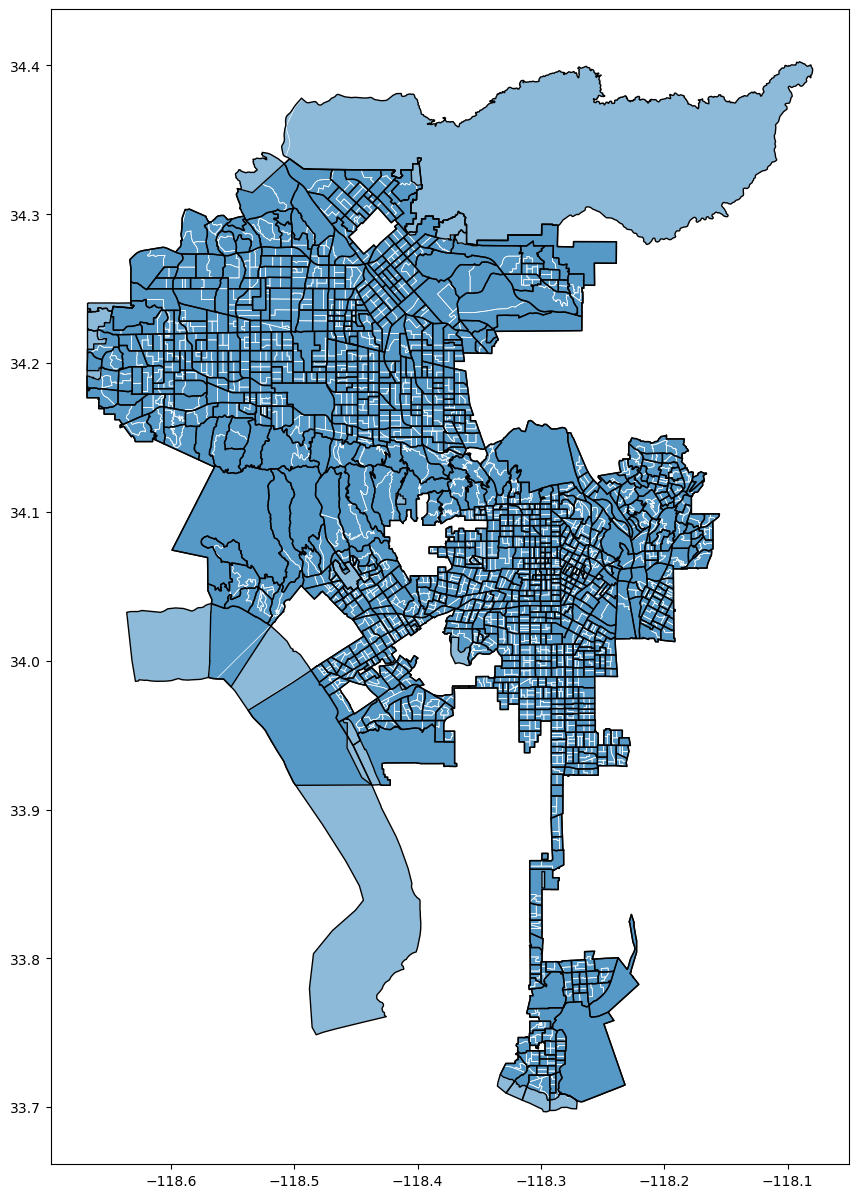

In [12]:
# compare
fig,ax = plt.subplots(figsize=(15,15))

# blue background of census tracts
gdf_tracts.plot(ax=ax,zorder=10,alpha=0.5)

# while lines to show block groups (sandwiched between the two layers above for visual clarity)
gdf_bg.boundary.plot(ax=ax,color='white',zorder=15,lw=0.5)

# black boundary lines of census tracts on top of everything
gdf_tracts.boundary.plot(ax=ax,color='black',zorder=20,lw=1)

In [13]:
# trim the data to the bare minimum columns
gdf_bg = gdf_bg[['geoid','B01003001','geometry']]

# rename the columns
gdf_bg.columns = ['FIPS','TotalPop','geometry']

In [14]:
gdf_bg.drop(gdf_bg.tail(1).index,inplace=True)

In [15]:
# fix FIPS code
gdf_bg['FIPS'] = gdf_bg['FIPS'].str.replace('15000US','')

In [16]:
gdf_bg = gdf_bg.to_crs(epsg=3857)

In [17]:
arrests = gpd.GeoDataFrame(latlon_drinking, 
                         crs='EPSG:4326',
                         geometry=gpd.points_from_xy(latlon_drinking.lon, latlon_drinking.lat))

In [18]:
arrests = arrests.to_crs(epsg=3857)

In [19]:
arrests.lon = arrests.lon.astype('float')
arrests.lat = arrests.lat.astype('float')

In [20]:
arrests = arrests.drop(['index_left'], axis=1)

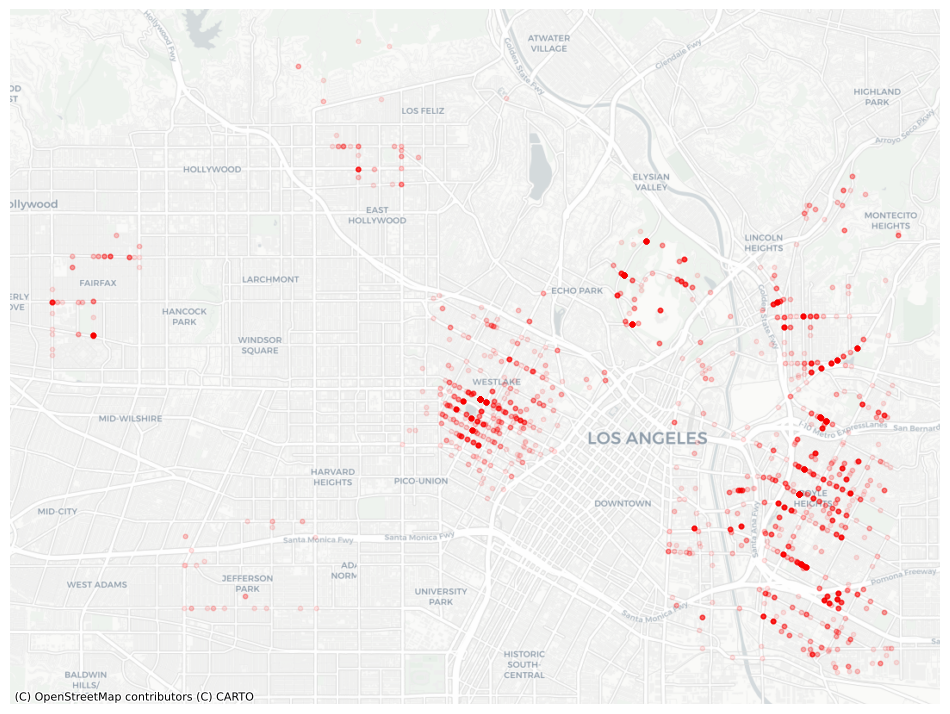

In [21]:
fig,ax = plt.subplots(figsize=(12,12))

arrests.plot(ax=ax,
             color='red',
             markersize=10, alpha=0.1)

# no axis
ax.axis('off')

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

In [22]:
# get the bounding box coordinates for the arrest data
minx, miny, maxx, maxy = arrests.geometry.total_bounds
print(minx)
print(maxx)
print(miny)
print(maxy)

-13175930.77757897
-13157173.443380304
4030802.9076084937
4044818.926018922


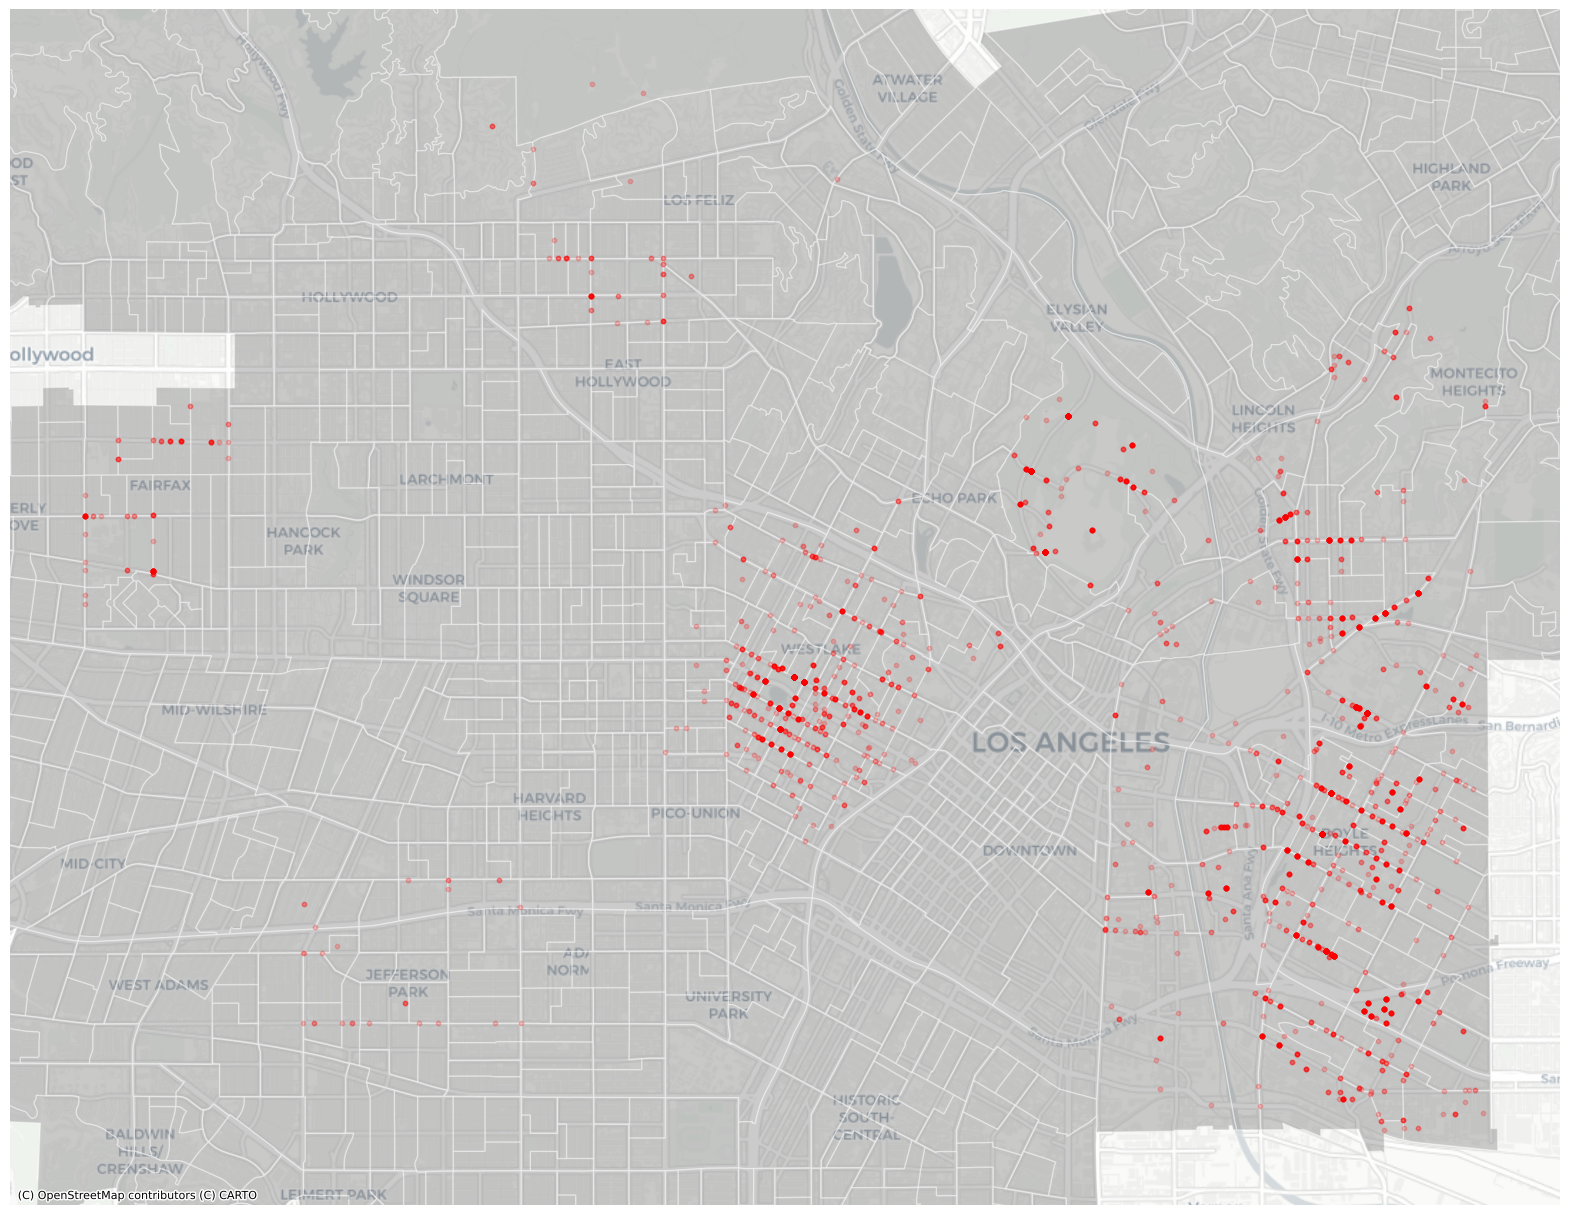

In [23]:
# set up the plot canvas with plt.subplots
fig, ax = plt.subplots(figsize=(20, 20))

# block groups
gdf_bg.plot(ax=ax, # this puts it in the ax plot
        color='gray', 
        edgecolor='white',
        alpha=0.4)

# arrests
arrests.plot(ax=ax, # this also puts it in the same ax plot
        color='red',
        markersize=10,
        alpha=0.2)

# use the bounding box coordinates to set the x and y limits
ax.set_xlim(minx - 1000, maxx + 1000) # added/substracted value is to give some margin around total bounds
ax.set_ylim(miny - 1000, maxy + 1000)

# no axis
ax.axis('off')

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

In [24]:
arrests.shape

(3280, 21)

In [25]:
join = gpd.sjoin(gdf_bg, arrests, how='left')

In [26]:
arrests_by_bg = join.FIPS.value_counts().rename_axis('FIPS').reset_index(name='arrests_count')
arrests_by_bg

FIPS  arrests_count
0     060372088011            337
1     060379800101            269
2     060372033001            169
3     060372048103            112
4     060372044201            112
...            ...            ...
2679  060371397051              1
2680  060371397052              1
2681  060371397053              1
2682  060371398011              1
2683  060379902000              1

[2684 rows x 2 columns]

In [27]:
gdf_count=gdf_bg.merge(arrests_by_bg,on='FIPS')

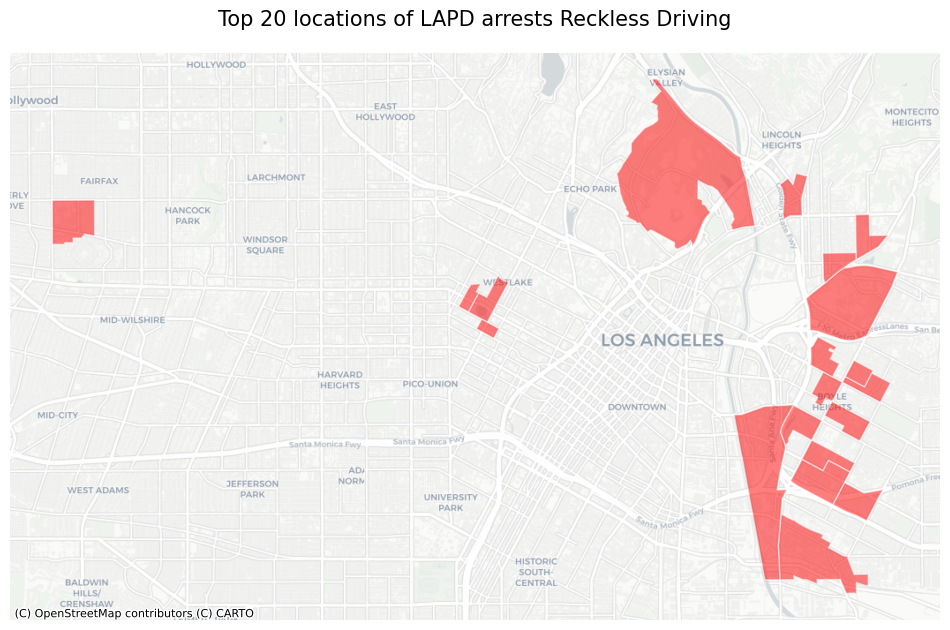

In [28]:
# map the top 20 geographies
fig,ax = plt.subplots(figsize=(12,10))
gdf_count.sort_values(by='arrests_count',ascending=False)[:20].plot(ax=ax,
                                                                 color='red',
                                                                 edgecolor='white',
                                                                 alpha=0.5)


# title
ax.set_title('Top 20 locations of LAPD arrests Reckless Driving',fontsize=15,pad=20)

# no axis
ax.axis('off')

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

In [29]:
gdf_filtered = gdf_count.query('arrests_count > 38')
gdf_filtered.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 20 entries, 1283 to 2669
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   FIPS           20 non-null     object  
 1   TotalPop       20 non-null     float64 
 2   geometry       20 non-null     geometry
 3   arrests_count  20 non-null     int64   
dtypes: float64(1), geometry(1), int64(1), object(1)
memory usage: 800.0+ bytes


In [30]:
import folium

In [31]:
dt = [34.049425, -118.246379]

m = folium.Map(location=dt, 
               zoom_start=12,
              tiles='CartoDB Positron')

threshold_scale = [0,50, 100, 150, 200, 250, 300, 350]  # boundaries between color classes

folium.Choropleth(
    geo_data=gdf_filtered,
    data=gdf_filtered,
    key_on='feature.properties.FIPS',
    columns=['FIPS','arrests_count'],
    fill_color='Reds',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Number of Public Drinking Arrests',
    smooth_factor=0,
    threshold_scale=threshold_scale,
    
).add_to(m)

m

In [32]:
icone1 = folium.Icon(icon="tree", icon_color="white", color="darkgreen", prefix="fa",)
marker1 = folium.Marker([34.073744, -118.355059], popup='Pan Pacific Park', icon=icone1)
marker1.add_to(m)

icone2 = folium.Icon(icon="tree", icon_color="white", color="darkgreen", prefix="fa")
marker2 = folium.Marker([34.038188, -118.204651], popup='Evergreen Recreation Center', icon=icone2)
marker2.add_to(m)

icone3 = folium.Icon(icon="tree", icon_color="white", color="lightgray", prefix="fa",)
marker3 = folium.Marker([34.062594, -118.284102], popup='Lafayette Park', icon=icone3)
marker3.add_to(m)

icone4 = folium.Icon(icon="tree", icon_color="white", color="darkgreen", prefix="fa",)
marker4 = folium.Marker([34.058964, -118.278089], popup='MacArthur Park', icon=icone4)
marker4.add_to(m)

icone6 = folium.Icon(icon="tree", icon_color="white", color="darkgreen", prefix="fa",)
marker6 = folium.Marker([34.077254, -118.239923], popup='Elysian Park, Dodgers Stadium', icon=icone6)
marker6.add_to(m)

icone7 = folium.Icon(icon="tree", icon_color="white", color="lightgray", prefix="fa",)
marker7 = folium.Marker([34.040483, -118.197562], popup='Evergreen Cemetery', icon=icone7)
marker7.add_to(m)

icone8 = folium.Icon(icon="tree", icon_color="white", color="darkgreen", prefix="fa",)
marker8 = folium.Marker([34.039177, -118.218300], popup='Hollenbeck Park', icon=icone8)
marker8.add_to(m)

icone9 = folium.Icon(icon="tree", icon_color="white", color="lightgray", prefix="fa",)
marker9 = folium.Marker([34.066862, -118.200778], popup='Lincoln Park', icon=icone9)
marker9.add_to(m)

icone10 = folium.Icon(icon="tree", icon_color="white", color="darkgreen", prefix="fa",)
marker10 = folium.Marker([34.059237, -118.201524], popup='Hazard Recreation Center', icon=icone10)
marker10.add_to(m)

icone13 = folium.Icon(icon="tree", icon_color="white", color="darkgreen", prefix="fa",)
marker13 = folium.Marker([34.021077, -118.211124], popup='Lou Costello Jr Recreation Center', icon=icone13)
marker13.add_to(m)

icone11 = folium.Icon(icon="tree", icon_color="white", color="darkgreen", prefix="fa",)
marker11 = folium.Marker([34.027104, -118.206377], popup='Ramon Garcia Recreation Center', icon=icone11)
marker11.add_to(m)

icone12 = folium.Icon(icon="tree", icon_color="white", color="darkgreen", prefix="fa",)
marker12 = folium.Marker([34.032628, -118.214336], popup='Boyle Beights Recreation Center', icon=icone12)
marker12.add_to(m)
m

In [64]:
m.save('drinkingmap.html')

In [44]:
dt = [34.049425, -118.246379]

d = folium.Map(location=dt, 
               zoom_start=12,
              tiles='CartoDB Positron')

threshold_scale = [0,50, 100, 150, 200, 250, 300, 350]  # boundaries between color classes

folium.Choropleth(
    geo_data=gdf_filtered,
    data=gdf_filtered,
    key_on='feature.properties.FIPS',
    columns=['FIPS','arrests_count'],
    fill_color='Reds',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Number of Public Drinking Arrests',
    smooth_factor=0,
    threshold_scale=threshold_scale,
    
).add_to(d)

In [35]:
transit = pd.read_csv('Metro_Stations.csv')

In [36]:
for index, row in transit.iterrows():
    print(row.Name, row.latitude, row.longitude)

Union Station 34.05605499 -118.23644042
Long Beach Transit Mall 33.768069 -118.192689
1st Street Metro Station 33.768078 -118.189832
Pacific Metro Station 33.772137 -118.193715
5th Street Metro Station 33.772348 -118.189364
Anaheim Metro Station 33.782302 -118.189359
PCH Metro Station 33.789566 -118.189361
Willow Metro Station 33.806285 -118.189487
Wardlow Metro Station 33.819397 -118.195716
Del Amo Metro Station 33.847566 -118.210822
Artesia Metro Station 33.876644 -118.222793
Compton Metro Station 33.896314 -118.224232
Imperial / Wilmington (Rosa Parks) Metro Station 33.929046 -118.23805
103rd Street Metro Station 33.942702 -118.24324
Firestone Metro Station 33.959616 -118.243261
Florence Metro Station 33.974346 -118.24331
Slauson Metro Station 33.987604 -118.243195
Vernon Metro Station 34.003194 -118.243138
Washington Metro Station 34.020406 -118.242825
San Pedro Metro Station 34.027081 -118.256067
Grand Metro Station 34.033017 -118.268996
Pico Metro Station 34.040422 -118.266455
7t

In [38]:
for index, row in transit.iterrows():
    # add folium marker code
    folium.Circle([row.latitude, row.longitude], 
                  popup=row.Name, 
                  tooltip=row.description,
                 color = 'gray').add_to(d)
d

In [40]:
purplepoints = [ ( 34.061753 , -118.301458 ) ,
( 34.061689 , -118.308756 ) ,
( 34.062701 , -118.290082 ) ,
( 34.056368 , -118.274879 ) ,
( 34.048634 , -118.258682 ) ,
( 34.049316 , -118.251259 ) ,
( 34.0549 , -118.246057 ) ,
( 34.056197 , -118.234249 )]

greenpoints=[( 33.89464 , -118.369196 ) ,
( 33.905299 , -118.383113 ) ,
( 33.916063 , -118.386539 ) ,
( 33.9232 , -118.387572 ) ,
( 33.929621 , -118.377134 ) ,
( 33.933408 , -118.351602 ) ,
( 33.925201 , -118.32655 ) ,
( 33.928683 , -118.291733 ) ,
( 33.928714 , -118.2811 ) ,
( 33.927465 , -118.265217 ) ,
( 33.928258 , -118.238052 ) ,
( 33.92488 , -118.209945 ) ,
( 33.91307 , -118.1406 ) ,
( 33.914033 , -118.104717 )]

goldpoint = [
( 34.033398 , -118.154469 ) ,
( 34.033364 , -118.161206 ) ,
( 34.033319 , -118.16814 ) ,
( 34.0343 , -118.192182 ) ,
( 34.043747 , -118.210061 ) ,
( 34.047215 , -118.219648 ) ,
( 34.047634 , -118.22594 ) ,
( 34.0501 , -118.237901 ) ,
( 34.056061 , -118.234759 ) ,
( 34.063861 , -118.23584 ) ,
( 34.080949 , -118.220429 ) ,
( 34.087227 , -118.213213 ) ,
( 34.098243 , -118.206712 ) ,
( 34.111179 , -118.192606 ) ,
( 34.115186 , -118.157886 ) ,
( 34.133521 , -118.148126 ) ,
( 34.14191 , -118.148214 ) ,
( 34.148356 , -118.147512 ) ,
( 34.151806 , -118.13139 ) ,
( 34.152417 , -118.114348 ) ,
( 34.147752 , -118.081212 ) ,
( 34.14286 , -118.029199 ) ,
( 34.133155 , -118.003473 ) ,
( 34.132518 , -117.96768 ) ,
( 34.129048 , -117.932506 ) ,
( 34.135863 , -117.906631 ) ,
( 34.136814 , -117.891636 ) ]

expopoints =[( 34.040735 , -118.266118 ) ,
( 34.04861 , -118.258822 ),
( 34.029112 , -118.273603 ) ,
( 34.022123 , -118.278118 ) ,
( 34.018227 , -118.285734 ) ,
( 34.018245 , -118.29154 ) ,
( 34.018331 , -118.30891 ) ,
( 34.022526 , -118.335078 ) ,
( 34.023981 , -118.346095 ) ,
( 34.024803 , -118.355159 ) ,
( 34.026355 , -118.37212 ) ,
( 34.027896 , -118.388986 ) ,
( 34.029323 , -118.404255 ) ,
( 34.036816 , -118.424576 ) ,
( 34.035408 , -118.434234 ) ,
( 34.031705 , -118.452896 ) ,
( 34.027995 , -118.46912 ) ,
( 34.023155 , -118.480372 ) ,
( 34.01401 , -118.491384 )]

red_points = [
( 34.168504 , -118.376808 ) ,
( 34.140002 , -118.362699 ) ,
( 34.101547 , -118.338549 ) ,
( 34.10163 , -118.32518 ) ,
( 34.101737 , -118.308117 ) ,
( 34.097708 , -118.291756 ) ,
( 34.08991 , -118.29173 ) ,
( 34.076526 , -118.291686 ),
( 34.062701 , -118.290082 ) ,
( 34.056368 , -118.274879 ) ,
( 34.048634 , -118.258682 ) ,
( 34.049316 , -118.251259 ) ,
( 34.0549 , -118.246057 ) ,
( 34.056197 , -118.234249 )]

blue_points = [( 33.768071 , -118.192921 ) ,
    ( 33.76874 , -118.189362 ) ,
( 33.773598 , -118.189412 ),
( 33.772258 , -118.1937 ) ,
( 33.78183 , -118.189384 ) ,
( 33.78909 , -118.189382 ) ,
( 33.807079 , -118.189834 ) ,
( 33.819865 , -118.19609 ) ,
( 33.848222 , -118.211017 ) ,
( 33.876082 , -118.222503 ) ,
( 33.89749 , -118.224249 ) ,
( 33.928048 , -118.237555 ) ,
( 33.94222 , -118.243159 ) ,
( 33.959611 , -118.243205 ) ,
( 33.97374 , -118.243271 ) ,
( 33.98876 , -118.243398 ) ,
( 34.00292 , -118.243303 ) ,
( 34.01965 , -118.243084 ) ,
( 34.026807 , -118.255505 ) ,
( 34.033155 , -118.269333 ) ,
( 34.040735 , -118.266118 ),
( 34.04861 , -118.258822 )]


In [45]:
folium.PolyLine(red_points,
               color="red",
               weight =4,
               opacity=.5).add_to(d)

folium.PolyLine(blue_points,
               color="blue",
               weight =4,
               opacity=.5).add_to(d)

folium.PolyLine(expopoints,
               weight =4,
               opacity=.5).add_to(d)

folium.PolyLine(goldpoint,
                color="gold",
               weight =4,
               opacity=.75).add_to(d)

folium.PolyLine(greenpoints,
                color="green",
               weight =4,
               opacity=.75).add_to(d)

folium.PolyLine(purplepoints,
                color="purple",
               weight =4,
               opacity=.75).add_to(d)

In [46]:
icone16 = folium.Icon(icon="train", icon_color="white", color="red", prefix="fa",)
marker16 = folium.Marker([ 34.05723, -118.276328], popup='Westlake / McArthur Park Metro Station', icon=icone16)
marker16.add_to(d)

icone18 = folium.Icon(icon="train", icon_color="white", color="orange", prefix="fa",)
marker18 = folium.Marker([ 34.081264, -118.219958], popup='Lincoln Heights / Cypress Park Metro Station', icon=icone18)
marker18.add_to(d)


icone19 = folium.Icon(icon="train", icon_color="white", color="orange", prefix="fa",)
marker19 = folium.Marker([ 34.043759, -118.209729], popup='Soto Metro Station', icon=icone19)
marker19.add_to(d)

d

In [47]:
d.save('drinktransitmap.html')